## Video Action Classification

In [1]:
import os
import pickle
import time
import copy

import numpy as np
numpy_seed = np.random.get_state()
print(numpy_seed)
# np.random.set_state(numpy_seed)
import torch
torch_seed = torch.initial_seed()
print(torch_seed)
# torch.manual_seed(torch_seed)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_packed_sequence, pack_sequence, pack_padded_sequence
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from apex import amp

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device : {}".format(dev))
print(torch.cuda.device_count())

('MT19937', array([2147483648, 2017631812, 1215739787,  854213809, 1254296875,
       1964567758, 2912052591,  614204743,  265203830, 3805589938,
       2619056934, 1298743154, 2341183235, 4139747209, 1337404554,
       2174883897, 2662786286, 3089421538,  396434908, 2587623392,
        423874155,  662060000, 3858643843, 2080932179, 3224335063,
       3672926410, 2237824479, 3630368248, 1216710477, 2571669438,
       1203461638, 2342716088,  860664532, 3074320824, 2548316185,
        430713079, 1954860268, 3996255332, 2944781176, 1581975184,
       3659603993, 4227022869, 1031885500,  959049778, 2315734287,
       2994955061, 3205595180,  908849840, 3505327159, 3612447255,
        791484752,  479174740, 3045991974, 3626669372, 3012314609,
        508111378,  728411154, 1600710094,  534199146, 2085013725,
       2082436183, 3745589303, 3471521622, 3796283997, 1907621291,
       3511846484,  226466434, 4040112276, 1936884122, 2944136621,
       3438489614, 1536083029,  300604242, 3814295

Load dataset

In [2]:
# pickle_filename = 'data.pickle'

# if os.path.isfile(pickle_filename):
#     with open(pickle_filename, 'rb') as file:
#         train_data_feat, train_data_labels, test_data_feat = pickle.load(file)
# else:
#     from read_datasetBreakfast import load_data, read_mapping_dict

#     COMP_PATH = ''

#     ''' 
#     training to load train set
#     test to load test set
#     '''
#     train_split =  os.path.join(COMP_PATH, 'splits/train.split1.bundle') #Train Split
#     test_split  =  os.path.join(COMP_PATH, 'splits/test.split1.bundle') #Test Split
#     GT_folder   =  os.path.join(COMP_PATH, 'groundTruth/') #Ground Truth Labels for each training video 
#     DATA_folder =  os.path.join(COMP_PATH, 'data/') #Frame I3D features for all videos
#     mapping_loc =  os.path.join(COMP_PATH, 'splits/mapping_bf.txt') 

#     actions_dict = read_mapping_dict(mapping_loc)
#     train_data_feat, train_data_labels = load_data( train_split, actions_dict, GT_folder, DATA_folder, datatype = "training") #Get features and labels
#     test_data_feat = load_data( test_split, actions_dict, GT_folder, DATA_folder, datatype = "test") #Get features only
    
#     with open(pickle_filename, 'wb') as file:
#         pickle.dump((train_data_feat, train_data_labels, test_data_feat), file)

# print(len(train_data_feat))
# print(len(train_data_labels))
# print(len(test_data_feat))

```python
print(len(train_data_feat))
print(len(train_data_labels))
print(len(test_data_feat))
> 1460
> 1460
> 252
```

Flatten dataset

In [3]:
# with open("training_segment.txt", 'r') as file:
#     training_segment = [[int(a) for a in line.split()] for line in file]

# # tot_segment_len = 0
# # n_segment_len = 0
# # max_segment_len = 0
# # min_segment_len = float("inf")

# train_feat_flat = []
# train_labels_flat = []
# train_flat_idx = []
# for video_idx, video_segments in enumerate(tqdm(training_segment)):
#     for i in range(len(video_segments)-1):
#         segment_len = video_segments[i+1] - video_segments[i]
# #         tot_segment_len += segment_len
# #         n_segment_len += 1
# #         if segment_len > max_segment_len:
# #             max_segment_len = segment_len
# #         if segment_len < min_segment_len:
# #             min_segment_len = segment_len
#         train_flat_idx.append(len(train_feat_flat))
#         train_feat_flat.extend(train_data_feat[video_idx][video_segments[i]:video_segments[i+1]])
#         train_labels_flat.extend([(train_data_labels[video_idx][i])-1]*segment_len)
# train_flat_idx.append(len(train_feat_flat))

# # avg_segment_len = tot_segment_len / n_segment_len
# # print(avg_segment_len, max_segment_len, min_segment_len)

```python
print(avg_segment_len, max_segment_len, min_segment_len)
> 404.3518021201413 5791 8
```

Pickle (or load) flatten dataset

In [4]:
num_split = 10
load_split = 10

files_exist = []
for i in range(num_split):
    pickle_filename = "flatten_data_{}.pickle".format(i)
    files_exist.append(os.path.isfile(pickle_filename))

if not all(files_exist):
    max_len = len(train_feat_flat)
    split_len = max_len//num_split
    for i in tqdm(range(num_split)):
        pickle_filename = "flatten_data_{}.pickle".format(i)
        start_idx = split_len*i
        end_idx = split_len*(i+1) if i < num_split-1 else max_len
        print(i, start_idx, end_idx)
        with open(pickle_filename, 'wb') as file:
            train_feat_split_tensor = torch.stack(train_feat_flat[start_idx:end_idx]).to(dtype=torch.float32)
            train_labels_split_tensor = torch.LongTensor(train_labels_flat[start_idx:end_idx])
            pickle.dump((train_feat_split_tensor, train_labels_split_tensor), file)
    with open("flatten_data_idx.txt", 'w') as file:
        for i in train_flat_idx:
            file.write("{} ".format(i))

train_feat_split_list = []
train_labels_split_list = []
for i in tqdm(range(load_split)):
    pickle_filename = "flatten_data_{}.pickle".format(i)
    with open(pickle_filename, 'rb') as file:
        train_feat_split, train_labels_split = pickle.load(file)
        train_feat_split_list.append(train_feat_split)
        train_labels_split_list.append(train_labels_split)
with open("flatten_data_idx.txt", 'r') as file:
    train_flat_idx = [int(a) for line in file for a in line.split()]

train_feat_tensor = torch.cat(train_feat_split_list, dim=0)
train_labels_tensor = torch.cat(train_labels_split_list, dim=0)
print(train_feat_tensor.shape)
print(train_labels_tensor.shape)
print(len(train_flat_idx))
print(train_flat_idx[:10])


torch.Size([2860789, 400])
torch.Size([2860789])
7076
[0, 260, 465, 793, 1054, 1687, 5923, 7216, 7288, 7338]


Create Dataset

In [5]:
class VideoDataset(Dataset):
    
    def __init__(self, features, labels, training_segment_file):
        self.features = features
        self.labels = labels
        self.vid_indices = self._create_vid_indices(training_segment_file)
        self.len = len(self.vid_indices)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        indices = self.vid_indices[idx]
        vid_features = [self.features[indices[seg_idx]:indices[seg_idx+1]] for seg_idx in range(len(indices)-1)]
        vid_labels = [self.labels[indices[seg_idx]] for seg_idx in range(len(indices)-1)]
        return (vid_features, vid_labels)
    
    def _create_vid_indices(self, training_segment_file):
        with open(training_segment_file, 'r') as file:
            training_segment = [[int(a) for a in line.split()] for line in file]
        vid_indices = []
        last_seg_idx = 0
        for vid in training_segment:
            vid_indices.append([seg-vid[0]+last_seg_idx for seg in vid])
            last_seg_idx = vid_indices[-1][-1]
        return vid_indices

In [6]:
class SegmentDataset(Dataset):
    
    def __init__(self, vid_dataset):
        self.vid_dataset = vid_dataset
        self.seg_to_vid, self.len = self._create_seg_to_vid_idx(self.vid_dataset)
    
    def _create_seg_to_vid_idx(self, vid_dataset):
        seg_to_vid = {}
        i = 0
        for vid_i, (_, labels) in enumerate(self.vid_dataset):
            for seg_i in range(len(labels)):
                seg_to_vid[i] = (vid_i, seg_i)
                i += 1
        return seg_to_vid, i

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        vid_i, seg_i = self.seg_to_vid[idx]
        return (self.vid_dataset[vid_i][0][seg_i], self.vid_dataset[vid_i][1][seg_i])

Split dataset

In [7]:
vid_dataset = VideoDataset(train_feat_tensor, train_labels_tensor, "training_segment.txt")

tot_len = len(vid_dataset)
print("Number of training video: {}".format(tot_len))

train_split_size = 0.85
lengths = [int(tot_len*train_split_size), tot_len - int(tot_len*train_split_size)]

vid_train_dataset, vid_val_dataset = torch.utils.data.random_split(vid_dataset, lengths)

seg_train_dataset = SegmentDataset(vid_train_dataset)
seg_val_dataset = SegmentDataset(vid_val_dataset)

print("Training data (video, segments): ({}, {})".format(len(vid_train_dataset), len(seg_train_dataset)))
print("Validation data (video, segments): ({}, {})".format(len(vid_val_dataset), len(seg_val_dataset)))

Number of training video: 1460
Training data (video, segments): (1241, 6034)
Validation data (video, segments): (219, 1041)


Define segment training routine

In [8]:
def seg_train_val(num_epoch, dataloader_dict, model, loss, optimizer, print_epoch=True, device=None):
    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []
    best_acc = 0.0
    best_model_weights = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epoch):
        since = time.time()
        if print_epoch:
            print("Epoch {}/{}".format(epoch+1, num_epoch))
            print("-----------")
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else :
                model.eval()
            total_loss = 0.0
            total_correct = 0.0
            for X, y, batch_len in dataloader_dict[phase]:
                if device is not None:
                    X = X.to(device)
                    y = y.to(device)
                with torch.set_grad_enabled(phase == "train"):
                    y_tilde = model(X)
                    L = loss(y_tilde, y)
                    if phase == "train":
                        optimizer.zero_grad()
#                         L.backward()
                        with amp.scale_loss(L, optimizer) as scaled_loss:
                            scaled_loss.backward()
                        optimizer.step()
                y_tilde_label = torch.argmax(y_tilde, dim=1)
                num_correct = torch.sum((y_tilde_label == y))
                
                total_loss += L.item() * batch_len
                total_correct += num_correct.item()
            
            epoch_loss = total_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = (total_correct / len(dataloader_dict[phase].dataset)) * 100
            
            if phase == "val":
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_weights = copy.deepcopy(model.state_dict())
            if phase == "train":
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)

            if print_epoch:
                print("{} | Loss : {:.4f}  Acc : {:.2f}%".format(phase.capitalize().ljust(5), epoch_loss, epoch_acc))
        
        print("Time elapsed : {:.2f} s".format(time.time() - since))
        print()
    
    model.load_state_dict(best_model_weights)
    return model, (val_acc_history, val_loss_history, train_acc_history, train_loss_history)

Define segment model

In [9]:
class SegmentModel(nn.Module):
    def __init__(self):
        super(SegmentModel, self).__init__()
        self.dropout1 = nn.Dropout(p=0.2)
        self.num_layers = 2
        self.lstm = nn.LSTM(400, 512, batch_first=True, num_layers=self.num_layers, dropout=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        self.linear = nn.Linear(512*(2+self.num_layers), 47)
        self.padding_value = 0
    def forward(self, x):
        x_pad, lengths = pad_packed_sequence(x, batch_first=True, padding_value=self.padding_value)
        x_pad = self.dropout1(x_pad)
        x = pack_padded_sequence(x_pad, lengths, batch_first=True, enforce_sorted=False)
        
        h, (h_last, c) = self.lstm(x)
        
        h_pad, lengths = pad_packed_sequence(h, batch_first=True, padding_value=self.padding_value)
        h_avg_pool = torch.sum(h_pad, 1) / (torch.sum((h_pad != self.padding_value), 1) + 1e-5)
        h_max_pool = torch.max(h_pad, 1)[0]
        x = torch.cat((*(h_last.unbind()), h_avg_pool, h_max_pool), 1)
        
        x = self.dropout2(x)
        
        x = self.linear(x)
        return x

seg_model = SegmentModel()
for param in seg_model.parameters():
    print(param.size())

torch.Size([2048, 400])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048, 512])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([2048])
torch.Size([47, 2048])
torch.Size([47])


Create segment DataLoader

In [10]:
def seg_collate(batch_data):
    features = []
    labels = []
    for feature, label in batch_data:
        features.append(feature)
        labels.append(label)
    return (pack_sequence(features, enforce_sorted=False), torch.tensor(labels), len(batch_data))

seg_train_loader = DataLoader(seg_train_dataset, batch_size=48, shuffle=True, pin_memory=True, collate_fn=seg_collate)
seg_val_loader = DataLoader(seg_val_dataset, batch_size=48, shuffle=True, pin_memory=True, collate_fn=seg_collate)

Start segment level training

In [11]:
seg_model = SegmentModel()
seg_model.to(dev)
seg_loss = nn.CrossEntropyLoss()
seg_optimizer = optim.Adam(seg_model.parameters())

# apex
seg_model, seg_optimizer = amp.initialize(seg_model, seg_optimizer, opt_level="O1")

seg_trained_model, seg_acc_loss = seg_train_val(100, {"train": seg_train_loader, "val": seg_val_loader}, seg_model, seg_loss, seg_optimizer, device=dev)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 1/100
-----------
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Train | Loss : 2.9807  Acc : 20.47%
Val   | Loss : 2.4053  Acc : 30.74%
Time elapsed : 107.18 s

Epoch 2/100
-----------
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Train | 

In [12]:
def plot_train_val(acc_loss):
    plt.figure(figsize=(18, 5))
    epoch_num = range(1, len(acc_loss[0])+1)
    plt.subplot(1, 2, 1)
    plt.title('Accuracy')
    plt.ylim(0, 110)
    plt.grid(True)
    plt.plot(epoch_num, acc_loss[2], color="blue")
    plt.plot(epoch_num, acc_loss[0], color="red")
    blue_patch = mpatches.Patch(color='blue', label='Training')
    red_patch = mpatches.Patch(color='red', label='Validation')
    plt.legend(handles=[blue_patch, red_patch])
    plt.subplot(1, 2, 2)
    plt.title('Loss')
    plt.ylim(0, 3)
    plt.grid(True)
    plt.plot(epoch_num, acc_loss[3], color="blue")
    plt.plot(epoch_num, acc_loss[1], color="red")
    blue_patch = mpatches.Patch(color='blue', label='Training')
    red_patch = mpatches.Patch(color='red', label='Validation')
    plt.legend(handles=[blue_patch, red_patch])

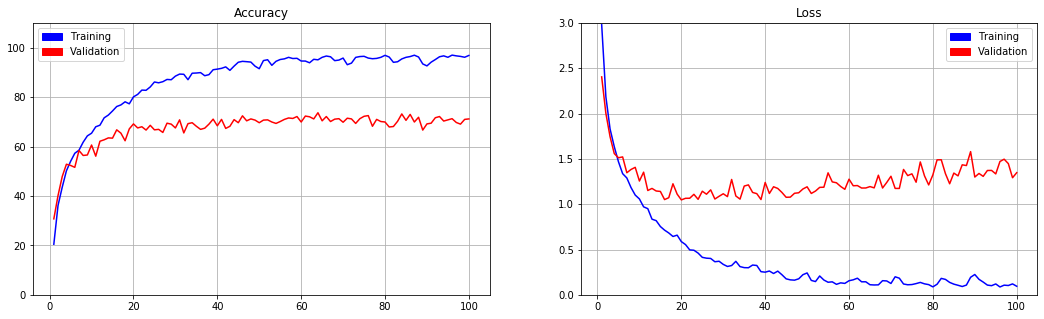

In [13]:
plot_train_val(seg_acc_loss)

In [14]:
print(max(seg_acc_loss[0]))

73.67915465898174


In [15]:
def set_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [16]:
set_lr(seg_optimizer, 0.0001)
seg_trained_model_tuning, seg_acc_loss_tuning = seg_train_val(50, {"train": seg_train_loader, "val": seg_val_loader}, seg_trained_model, seg_loss, seg_optimizer, device=dev)

Epoch 1/50
-----------
Train | Loss : 0.0723  Acc : 97.75%
Val   | Loss : 1.1441  Acc : 74.06%
Time elapsed : 100.65 s

Epoch 2/50
-----------
Train | Loss : 0.0577  Acc : 98.09%
Val   | Loss : 1.1248  Acc : 73.87%
Time elapsed : 100.43 s

Epoch 3/50
-----------
Train | Loss : 0.0461  Acc : 98.54%
Val   | Loss : 1.1459  Acc : 73.10%
Time elapsed : 100.32 s

Epoch 4/50
-----------
Train | Loss : 0.0375  Acc : 98.96%
Val   | Loss : 1.1047  Acc : 74.26%
Time elapsed : 101.13 s

Epoch 5/50
-----------
Train | Loss : 0.0380  Acc : 98.91%
Val   | Loss : 1.0974  Acc : 74.35%
Time elapsed : 101.54 s

Epoch 6/50
-----------
Train | Loss : 0.0272  Acc : 99.45%
Val   | Loss : 1.1017  Acc : 74.06%
Time elapsed : 102.57 s

Epoch 7/50
-----------
Train | Loss : 0.0239  Acc : 99.55%
Val   | Loss : 1.1056  Acc : 73.78%
Time elapsed : 100.41 s

Epoch 8/50
-----------
Train | Loss : 0.0275  Acc : 99.35%
Val   | Loss : 1.1099  Acc : 74.74%
Time elapsed : 98.95 s

Epoch 9/50
-----------
Train | Loss : 0.0

In [17]:
print(max(seg_acc_loss_tuning[0]))

75.98463016330452


Save segment model

In [40]:
best_seg_model = SegmentModel()
best_seg_model.load_state_dict(copy.deepcopy(seg_trained_model_tuning.state_dict()))

# model_filename = "lstm_val77_train99_2layers_512hidden.model"
timestamp = time.strftime("%y-%m-%d_%H:%M:%S", time.localtime())
segment_model_filename = timestamp + ".segment.model"
seeds_filename = timestamp + ".seeds"
with open(segment_model_filename, 'wb') as file:
    pickle.dump(best_seg_model, file)
with open(seeds_filename, 'wb') as file:
    pickle.dump((numpy_seed, torch_seed), file)
# with open(segment_model_filename, 'rb') as file:
#         seg_trained_model_tuning = pickle.load(file)

<All keys matched successfully>

Define video model

In [41]:
class VideoModel(nn.Module):
    def __init__(self, seg_model):
        super(VideoModel, self).__init__()
        
        self.seg_model = seg_model
        self.disable_parameters_grad(self.seg_model)
        
        self.num_layers = 2
        self.lstm = nn.LSTM(47, 512, batch_first=True, num_layers=self.num_layers, dropout=0.5)
        self.dropout = nn.Dropout(p=0.5)
        self.linear = nn.Linear(512, 47)
        self.padding_value = 0
        
    def forward(self, x, x_vid_len):
        y_flatten_seg = self.seg_model(x)
        
        y_seg = []
        last_i = 0
        for l in x_vid_len:
            y_seg.append(y_flatten_seg[last_i:last_i+l])
            last_i += l
        y_seg_seq = pack_sequence(y_seg, enforce_sorted=False)
        y_vid, _ = self.lstm(y_seg_seq)
        y_vid_pad, y_vid_lengths = pad_packed_sequence(y_vid, batch_first=True, padding_value=self.padding_value)
        y_vid_pad = self.dropout(y_vid_pad)
        y_vid_pad = self.linear(y_vid_pad)
        y_flatten_vid = torch.cat(tuple(vid[0:y_vid_lengths[i]] for i, vid in enumerate(y_vid_pad)))
        
        return y_flatten_vid
    
    def disable_parameters_grad(self, model):
        for param in model.parameters():
            param.requires_grad = False


vid_model = VideoModel(best_seg_model)
for param in vid_model.parameters():
    print(param.size(), param.requires_grad)

torch.Size([2048, 400]) False
torch.Size([2048, 512]) False
torch.Size([2048]) False
torch.Size([2048]) False
torch.Size([2048, 512]) False
torch.Size([2048, 512]) False
torch.Size([2048]) False
torch.Size([2048]) False
torch.Size([47, 2048]) False
torch.Size([47]) False
torch.Size([2048, 47]) True
torch.Size([2048, 512]) True
torch.Size([2048]) True
torch.Size([2048]) True
torch.Size([2048, 512]) True
torch.Size([2048, 512]) True
torch.Size([2048]) True
torch.Size([2048]) True
torch.Size([47, 512]) True
torch.Size([47]) True


Create video DataLoader

In [42]:
def vid_collate(batch_data):
    features = []
    labels = []
    vid_len = []
    for feature, label in batch_data:
        features.extend(feature)
        labels.extend(label)
        vid_len.append(len(feature))
    return (pack_sequence(features, enforce_sorted=False), torch.tensor(vid_len), torch.tensor(labels), len(batch_data))

vid_train_loader = DataLoader(vid_train_dataset, batch_size=4, shuffle=True, pin_memory=True, collate_fn=vid_collate)
vid_val_loader = DataLoader(vid_val_dataset, batch_size=4, shuffle=True, pin_memory=True, collate_fn=vid_collate)

Define video training routine

In [43]:
def vid_train_val(num_epoch, dataloader_dict, seg_count_dict, model, loss, optimizer, print_epoch=True, device=None):
    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []
    best_acc = 0.0
    best_model_weights = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epoch):
        since = time.time()
        if print_epoch:
            print("Epoch {}/{}".format(epoch+1, num_epoch))
            print("-----------")
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else :
                model.eval()
            total_loss = 0.0
            total_correct = 0.0
            for X, X_vid_len, y, _ in dataloader_dict[phase]:
                if device is not None:
                    X = X.to(device)
                    X_vid_len = X_vid_len.to(device)
                    y = y.to(device)
                with torch.set_grad_enabled(phase == "train"):
                    y_tilde = model(X, X_vid_len)
                    L = loss(y_tilde, y)
                    if phase == "train":
                        optimizer.zero_grad()
                        L.backward()
                        optimizer.step()
                y_tilde_label = torch.argmax(y_tilde, dim=1)
                num_correct = torch.sum((y_tilde_label == y))
                
                total_loss += L.item() * torch.sum(X_vid_len)
                total_correct += num_correct.item()
                
            epoch_loss = total_loss / seg_count_dict[phase]
            epoch_acc = (total_correct / seg_count_dict[phase]) * 100
            
            if phase == "val":
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_weights = copy.deepcopy(model.state_dict())
            if phase == "train":
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)

            if print_epoch:
                print("{} | Loss : {:.4f}  Acc : {:.2f}%".format(phase.capitalize().ljust(5), epoch_loss, epoch_acc))
        
        print("Time elapsed : {:.2f} s".format(time.time() - since))
        print()
    
    model.load_state_dict(best_model_weights)
    return model, (val_acc_history, val_loss_history, train_acc_history, train_loss_history)

Start video level training

In [44]:
vid_model = VideoModel(best_seg_model)
vid_model.to(dev)
vid_loss = nn.CrossEntropyLoss()
vid_optimizer = optim.Adam(vid_model.parameters())

vid_trained_model, vid_acc_loss = vid_train_val(30, {"train": vid_train_loader, "val": vid_val_loader}, {"train": len(seg_train_dataset), "val": len(seg_val_dataset)}, vid_model, vid_loss, vid_optimizer, device=dev)

Epoch 1/30
-----------
Train | Loss : 1.7739  Acc : 58.44%
Val   | Loss : 1.0427  Acc : 75.22%
Time elapsed : 68.29 s

Epoch 2/30
-----------
Train | Loss : 0.6578  Acc : 88.40%
Val   | Loss : 0.7894  Acc : 80.40%
Time elapsed : 70.31 s

Epoch 3/30
-----------
Train | Loss : 0.4104  Acc : 93.83%
Val   | Loss : 0.6777  Acc : 83.77%
Time elapsed : 69.17 s

Epoch 4/30
-----------
Train | Loss : 0.3263  Acc : 95.53%
Val   | Loss : 0.6317  Acc : 84.92%
Time elapsed : 69.71 s

Epoch 5/30
-----------
Train | Loss : 0.2623  Acc : 96.83%
Val   | Loss : 0.6323  Acc : 84.34%
Time elapsed : 71.42 s

Epoch 6/30
-----------
Train | Loss : 0.2167  Acc : 97.40%
Val   | Loss : 0.5873  Acc : 85.49%
Time elapsed : 70.16 s

Epoch 7/30
-----------
Train | Loss : 0.1971  Acc : 97.98%
Val   | Loss : 0.5543  Acc : 85.98%
Time elapsed : 71.16 s

Epoch 8/30
-----------
Train | Loss : 0.1683  Acc : 98.13%
Val   | Loss : 0.5410  Acc : 86.94%
Time elapsed : 70.63 s

Epoch 9/30
-----------
Train | Loss : 0.1511  Ac

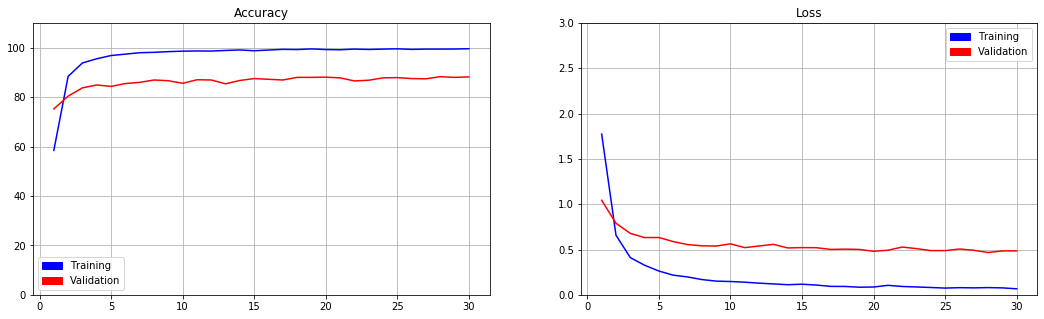

In [45]:
plot_train_val(vid_acc_loss)

In [46]:
print(max(vid_acc_loss[0]))

88.2804995196926


In [47]:
set_lr(vid_optimizer, 0.0001)
vid_trained_model_tuning, vid_acc_loss_tuning = vid_train_val(10, {"train": vid_train_loader, "val": vid_val_loader}, {"train": len(seg_train_dataset), "val": len(seg_val_dataset)}, vid_trained_model, vid_loss, vid_optimizer, device=dev)

Epoch 1/10
-----------
Train | Loss : 0.0685  Acc : 99.50%
Val   | Loss : 0.4538  Acc : 88.66%
Time elapsed : 71.85 s

Epoch 2/10
-----------
Train | Loss : 0.0598  Acc : 99.67%
Val   | Loss : 0.4619  Acc : 87.99%
Time elapsed : 70.45 s

Epoch 3/10
-----------
Train | Loss : 0.0547  Acc : 99.64%
Val   | Loss : 0.4687  Acc : 87.90%
Time elapsed : 70.52 s

Epoch 4/10
-----------
Train | Loss : 0.0493  Acc : 99.83%
Val   | Loss : 0.4696  Acc : 88.28%
Time elapsed : 72.47 s

Epoch 5/10
-----------
Train | Loss : 0.0484  Acc : 99.80%
Val   | Loss : 0.4730  Acc : 88.09%
Time elapsed : 71.13 s

Epoch 6/10
-----------
Train | Loss : 0.0483  Acc : 99.80%
Val   | Loss : 0.4716  Acc : 87.90%
Time elapsed : 71.56 s

Epoch 7/10
-----------
Train | Loss : 0.0481  Acc : 99.70%
Val   | Loss : 0.4630  Acc : 88.86%
Time elapsed : 70.58 s

Epoch 8/10
-----------
Train | Loss : 0.0462  Acc : 99.80%
Val   | Loss : 0.4610  Acc : 88.86%
Time elapsed : 71.09 s

Epoch 9/10
-----------
Train | Loss : 0.0445  Ac

In [48]:
print(max(vid_acc_loss_tuning[0]))

88.85686839577329


In [58]:
set_lr(vid_optimizer, 0.00001)
vid_trained_model_tuning1, vid_acc_loss_tuning1 = vid_train_val(10, {"train": vid_train_loader, "val": vid_val_loader}, {"train": len(seg_train_dataset), "val": len(seg_val_dataset)}, vid_trained_model_tuning, vid_loss, vid_optimizer, device=dev)

Epoch 1/10
-----------
Train | Loss : 0.0389  Acc : 99.85%
Val   | Loss : 0.4687  Acc : 88.76%
Time elapsed : 68.68 s

Epoch 2/10
-----------
Train | Loss : 0.0395  Acc : 99.80%
Val   | Loss : 0.4689  Acc : 88.57%
Time elapsed : 69.12 s

Epoch 3/10
-----------
Train | Loss : 0.0369  Acc : 99.88%
Val   | Loss : 0.4680  Acc : 88.76%
Time elapsed : 69.78 s

Epoch 4/10
-----------
Train | Loss : 0.0391  Acc : 99.78%
Val   | Loss : 0.4695  Acc : 88.76%
Time elapsed : 68.57 s

Epoch 5/10
-----------
Train | Loss : 0.0381  Acc : 99.85%
Val   | Loss : 0.4693  Acc : 88.76%
Time elapsed : 69.49 s

Epoch 6/10
-----------
Train | Loss : 0.0375  Acc : 99.93%
Val   | Loss : 0.4698  Acc : 88.57%
Time elapsed : 69.72 s

Epoch 7/10
-----------
Train | Loss : 0.0389  Acc : 99.77%
Val   | Loss : 0.4706  Acc : 88.57%
Time elapsed : 68.86 s

Epoch 8/10
-----------
Train | Loss : 0.0374  Acc : 99.85%
Val   | Loss : 0.4722  Acc : 88.57%
Time elapsed : 69.70 s

Epoch 9/10
-----------
Train | Loss : 0.0376  Ac

In [59]:
print(max(vid_acc_loss_tuning1[0]))

88.76080691642652
